---
---
# **PotatoBlight Data Analysis and Visualization**
---
---
---

In [ ]:
# Comment:  Imports and Libraries

import os
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import xgboost as xgb
from sklearn.metrics import mean_squared_error

from math import sqrt
from sklearn import preprocessing

%matplotlib inline
plt.style.use('seaborn')
plotColors = (list(mcolors.TABLEAU_COLORS)+list(mcolors.TABLEAU_COLORS)+list(mcolors.TABLEAU_COLORS))[:23]

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# **I. Data Acquisition**

---

In [ ]:
path = '/content/drive/My Drive/PotatoBlight.xls'
df = pd.read_excel(path)

In [ ]:
df.head(3)

,Date,jd,DAP,TMIN,TMAX,TMEAN,Rain days>0.1mm,GDD,Accu. GDD,Daily blight obsrv.,Tmin>8,Tmax<25,Rain,Count of IP requirements,1 if count=3,IP Result,Season
0,01-Nov-02,304,40,19.1,29.0,24.05,0,14.05,14.05,0.0,1,0,0,1,0,0,1
1,02-Nov-02,305,41,17.8,31.1,24.45,0,14.45,28.50,0.0,1,0,0,1,0,0,1
2,03-Nov-02,306,42,18.8,31.9,25.35,0,15.35,43.85,0.0,1,0,0,1,0,0,1


In [ ]:
backup = df.copy()

---

## **II. Preprocessing Crime Data**

---

### **1. Convert the data format**

---

In [ ]:
df.Date = pd.to_datetime(df.Date)
#df.index = pd.DatetimeIndex(df.Date)

In [ ]:
#df['month'] = df['Date'].dt.month 

In [ ]:
#df['day'] = df['Date'].dt.day

In [ ]:
#df['year'] = df['Date'].dt.year

In [ ]:
df = df.drop(['Date','jd','Tmin>8','Tmax<25','Rain','Count of IP requirements',\
                        '1 if count=3', 'Season'], axis=1)

In [ ]:
def get_mean_last_three_weeks(ds):
  mean_value = 0
  rows = ds.shape[0]
  meanlast3 = np.zeros(rows)
  mean_value = np.sum(ds[:2])
  meanlast3[:2] = mean_value / 2
  for i in range(2, rows):
      mean_value += ds[i]
      meanlast3[i] = mean_value / 3
      mean_value -= ds[i-2]
  return meanlast3

In [ ]:
df['lastDS'] = df['Daily blight obsrv.'].shift()
meanlast3DS = get_mean_last_three_weeks(np.array(df['Daily blight obsrv.']))
df['meanlast3DS'] = meanlast3DS
df.head()

,DAP,TMIN,TMAX,TMEAN,Rain days>0.1mm,GDD,Accu. GDD,Daily blight obsrv.,IP Result,lastDS,meanlast3DS
0,40,19.1,29.0,24.05,0,14.05,14.05,0.0,0,NaN,0.0
1,41,17.8,31.1,24.45,0,14.45,28.50,0.0,0,0.0,0.0
2,42,18.8,31.9,25.35,0,15.35,43.85,0.0,0,0.0,0.0
3,43,20.3,29.0,24.65,0,14.65,58.50,0.0,0,0.0,0.0
4,44,19.8,29.1,24.45,0,14.45,72.95,0.0,0,0.0,0.0


In [ ]:
df.dropna(inplace=True)
df.head()

,DAP,TMIN,TMAX,TMEAN,Rain days>0.1mm,GDD,Accu. GDD,Daily blight obsrv.,IP Result,lastDS,meanlast3DS
1,41,17.8,31.1,24.45,0,14.45,28.50,0.0,0,0.0,0.0
2,42,18.8,31.9,25.35,0,15.35,43.85,0.0,0,0.0,0.0
3,43,20.3,29.0,24.65,0,14.65,58.50,0.0,0,0.0,0.0
4,44,19.8,29.1,24.45,0,14.45,72.95,0.0,0,0.0,0.0
5,45,13.9,28.1,21.00,0,11.00,83.95,0.0,0,0.0,0.0


In [ ]:
column_names =['DAP','TMIN','TMAX','TMEAN','Rain days>0.1mm','GDD','Accu. GDD','IP Result',\
               'lastDS','meanlast3DS','Daily blight obsrv.']
df = df.reindex(columns=column_names)



In [ ]:
df.head()

,DAP,TMIN,TMAX,TMEAN,Rain days>0.1mm,GDD,Accu. GDD,IP Result,lastDS,meanlast3DS,Daily blight obsrv.
1,41,17.8,31.1,24.45,0,14.45,28.50,0,0.0,0.0,0.0
2,42,18.8,31.9,25.35,0,15.35,43.85,0,0.0,0.0,0.0
3,43,20.3,29.0,24.65,0,14.65,58.50,0,0.0,0.0,0.0
4,44,19.8,29.1,24.45,0,14.45,72.95,0,0.0,0.0,0.0
5,45,13.9,28.1,21.00,0,11.00,83.95,0,0.0,0.0,0.0


In [ ]:
X, y = df.iloc[:,:-1],df.iloc[:,-1]

In [ ]:
data_dmatrix = xgb.DMatrix(data=X,label=y)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)


In [ ]:
xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree =1, learning_rate = 0.6,
                max_depth = 5, alpha = 10, n_estimators = 30)

In [ ]:
xg_reg.fit(X_train,y_train)

preds = xg_reg.predict(X_test)

[11:48:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
rmse = np.sqrt(mean_squared_error(y_test, preds))
rrmse = np.sqrt(mean_squared_error(y_test, preds))/np.mean(y_test)
print("RMSE: %f" % (rmse*100))
print("RRMSE: %f " % (rrmse*100))

RMSE: 126.805028
RRMSE: 6.725478 


In [ ]:
#Predict Output
from sklearn import metrics
y_pred = xg_reg.predict(X_test)

# error
rrmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))/np.mean(y_test)
print('Relative root mean squared error percentage:', rrmse*100)

Relative root mean squared error percentage: 6.725477965783512


In [ ]:
params = {"objective":"reg:linear",'colsample_bytree': 0.9,'learning_rate': 0.6,
                'max_depth': 5, 'alpha': 10}

cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=200,
                    num_boost_round=50,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=123)


[11:45:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:45:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:45:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:45:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:45:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:45:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:45:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:45:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

In [ ]:
cv_results.head()

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,13.856078,0.054439,8.181351,10.456237
1,6.138816,0.023804,3.639812,4.754481
2,2.989632,0.023869,1.973085,2.795532
3,1.729946,0.038040,1.438820,2.410201
4,1.310406,0.025779,1.222237,2.374863


In [ ]:
print(cv_results["test-rmse-mean"].tail(1)*100)
print(((cv_results["test-rmse-mean"].tail(1))/np.mean(y_test))*100)


15    105.00492
Name: test-rmse-mean, dtype: float64
15    5.569245
Name: test-rmse-mean, dtype: float64


In [ ]:
xg_reg = xgb.train(params=params, dtrain=data_dmatrix, num_boost_round=10)

[11:46:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


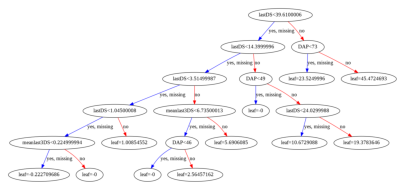

In [ ]:

xgb.plot_tree(xg_reg,num_trees=0)
plt.rcParams['figure.figsize'] = [40, 20]
plt.show()

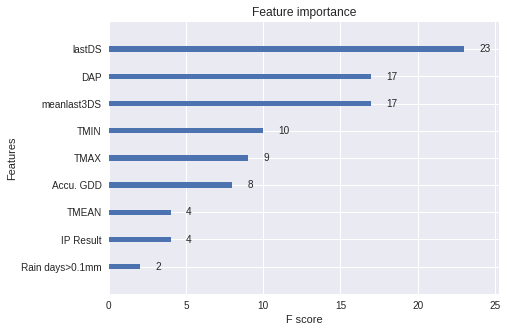

In [ ]:
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [5, 5]

plt.show()

In [ ]:
import sklearn.model_selection
from sklearn.model_selection import GridSearchCV 
from sklearn.metrics import confusion_matrix, mean_squared_error

In [ ]:
objective = "reg:linear"
seed = 100
n_estimators = 100
learning_rate = 0.1
gamma = 0.1
subsample = 0.8
colsample_bytree = 0.8
reg_alpha = 1
reg_lambda = 1
silent = False

parameters = {}
parameters['objective'] = objective
parameters['seed'] = seed
parameters['n_estimators'] = n_estimators
parameters['learning_rate'] = learning_rate
parameters['gamma'] = gamma
parameters['colsample_bytree'] = colsample_bytree
parameters['reg_alpha'] = reg_alpha
parameters['reg_lambda'] = reg_lambda
parameters['silent'] = silent

scores = []

cv_params = {'max_depth': [2,4,6,8],
             'min_child_weight': [1,3,5,7]
            }

gbm = GridSearchCV(xgb.XGBRegressor(
                                        objective = objective,
                                        seed = seed,
                                        n_estimators = n_estimators,
                                        learning_rate = learning_rate,
                                        gamma = gamma,
                                        subsample = subsample,
                                        colsample_bytree = colsample_bytree,
                                        reg_alpha = reg_alpha,
                                        reg_lambda = reg_lambda,
                                        silent = silent

                                    ),
                    
                    param_grid = cv_params,
                    iid = False,
                    scoring = "neg_mean_squared_error",
                    cv = 5,
                    verbose = True
)

gbm.fit(X_train,y_train)
print (gbm.cv_results_)
print ("Best parameters %s" %gbm.best_params_)
print ("Best score %s" %gbm.best_score_)


Fitting 5 folds for each of 16 candidates, totalling 80 fits
[12:01:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:01:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:01:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:01:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:01:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:01:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:01:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:01:42] WARNING: /workspace/src/objective/regre

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[12:01:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:01:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:01:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:01:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:01:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:01:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:01:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:01:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:    2.7s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


In [ ]:
max_depth = gbm.best_params_['max_depth']
min_child_weight = gbm.best_params_['min_child_weight']
parameters['max_depth'] = max_depth
parameters['min_child_weight'] = min_child_weight
scores.append(gbm.best_score_)

cv_params = {'max_depth': [max_depth-1, max_depth, max_depth+1], 
             'min_child_weight': [min_child_weight-1, min_child_weight-0.5, min_child_weight, min_child_weight+0.5, min_child_weight+1]
            }

gbm = GridSearchCV(xgb.XGBRegressor(
                                        objective = objective,
                                        seed = seed,
                                        n_estimators = n_estimators,
                                        learning_rate = learning_rate,
                                        gamma = gamma,
                                        subsample = subsample,
                                        colsample_bytree = colsample_bytree,
                                        reg_alpha = reg_alpha,
                                        reg_lambda = reg_lambda,
                                        silent = silent

                                    ),
                   
                    param_grid = cv_params,
                    iid = False,
                    scoring = "neg_mean_squared_error",
                    cv = 5,
                    verbose = True
)

gbm.fit(X_train,y_train)


Fitting 5 folds for each of 15 candidates, totalling 75 fits
[12:04:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:04:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:04:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:04:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:04:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:04:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[12:04:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:04:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:04:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:04:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:04:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:04:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:04:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:04:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:    3.0s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


GridSearchCV(cv=5, error_score=nan,
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=0.8, gamma=0.1,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=1, missing=None,
                                    n_estimators=100, n_jobs=1, nthread=None,
                                    objective='reg:linear', random_state=0,
                                    reg_alpha=1, reg_lambda=1,
                                    scale_pos_weight=1, seed=100, silent=False,
                                    subsample=0.8, verbosity=1),
             iid=False, n_jobs=None,
             param_grid={'max_depth': [5, 6, 7],
                         'min_child_weight': [0, 0.5, 1, 1.5, 2]},
             pre_

In [ ]:
print (gbm.cv_results_)
print ("Best parameters %s" %gbm.best_params_)
print ("Best score %s" %gbm.best_score_)

{'mean_fit_time': array([0.03437486, 0.03398294, 0.03245573, 0.03336802, 0.03547935,
       0.03896961, 0.03750262, 0.03738098, 0.03755531, 0.03749781,
       0.04129605, 0.04030352, 0.03958225, 0.04133134, 0.04038568]), 'std_fit_time': array([0.00367053, 0.00211199, 0.00095517, 0.00114991, 0.00201245,
       0.00180151, 0.00153416, 0.00127339, 0.0015286 , 0.00142135,
       0.00347351, 0.0017598 , 0.00097656, 0.00312035, 0.00187554]), 'mean_score_time': array([0.00176601, 0.00178819, 0.00180821, 0.00181069, 0.00219607,
       0.00181861, 0.00180182, 0.0020021 , 0.001964  , 0.00184331,
       0.00179548, 0.00200491, 0.00182481, 0.00196004, 0.00189672]), 'std_score_time': array([4.34294739e-05, 4.98180513e-05, 9.50942179e-05, 3.07342171e-05,
       2.97917385e-04, 8.26263175e-05, 3.98313470e-05, 2.97011665e-04,
       2.40577489e-04, 8.62704508e-05, 3.56613628e-05, 3.98244203e-04,
       7.14407099e-05, 1.68309198e-04, 6.94289640e-05]), 'param_max_depth': masked_array(data=[5, 5, 5, 5, 

In [ ]:
max_depth = gbm.best_params_['max_depth']
min_child_weight = gbm.best_params_['min_child_weight']
parameters['max_depth'] = max_depth
parameters['min_child_weight'] = min_child_weight
scores.append(gbm.best_score_)

cv_params = {'gamma': [i/10.0 for i in range(1,10,2)]}

gbm = GridSearchCV(xgb.XGBRegressor(
                                        objective = objective,
                                        seed = seed,
                                        n_estimators = n_estimators,
                                        max_depth = max_depth,
                                        min_child_weight = min_child_weight,
                                        learning_rate = learning_rate,
                                        subsample = subsample,
                                        colsample_bytree = colsample_bytree,
                                        reg_alpha = reg_alpha,
                                        reg_lambda = reg_lambda,
                                        silent = silent

                                    ),
                   
                    param_grid = cv_params,
                    iid = False,
                    scoring = "neg_mean_squared_error",
                    cv = 5,
                    verbose = True
)

gbm.fit(X_train,y_train)
print (gbm.cv_results_)
print ("Best parameters %s" %gbm.best_params_)
print ("Best score %s" %gbm.best_score_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[12:10:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:10:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:10:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:10:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:10:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[12:10:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:10:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:10:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:10:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:10:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:10:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:10:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:10:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    1.0s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


In [ ]:


gamma = gbm.best_params_['gamma']
parameters['gamma'] = gamma
scores.append(gbm.best_score_)

cv_params = {'subsample': [i/10.0 for i in range(6,11)],
             'colsample_bytree': [i/10.0 for i in range(6,11)]
            }

gbm = GridSearchCV(xgb.XGBRegressor(
                                        objective = objective,
                                        seed = seed,
                                        n_estimators = n_estimators,
                                        max_depth = max_depth,
                                        min_child_weight = min_child_weight,
                                        learning_rate = learning_rate,
                                        gamma = gamma,
                                        reg_alpha = reg_alpha,
                                        reg_lambda = reg_lambda,
                                        silent = silent

                                    ),
                   
                    param_grid = cv_params,
                    iid = False,
                    scoring = "neg_mean_squared_error",
                    cv = 5,
                    verbose = True
)

gbm.fit(X_train,y_train)
print (gbm.cv_results_)
print ("Best parameters %s" %gbm.best_params_)
print ("Best score %s" %gbm.best_score_)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[12:13:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:13:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:13:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:13:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:13:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:13:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[12:13:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:13:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:13:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:13:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:13:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:13:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:13:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:13:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    5.1s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


In [201]:
subsample = gbm.best_params_['subsample']
colsample_bytree = gbm.best_params_['colsample_bytree']
parameters['subsample'] = subsample
parameters['colsample_bytree'] = colsample_bytree
scores.append(gbm.best_score_)

cv_params = {'subsample': [i/100.0 for i in range(int((subsample-0.1)*100.0), min(int((subsample+0.1)*100),105) , 5)],
             'colsample_bytree': [i/100.0 for i in range(int((colsample_bytree-0.1)*100.0), min(int((subsample+0.1)*100),105), 5)]
            }

gbm = GridSearchCV(xgb.XGBRegressor(
                                        objective = objective,
                                        seed = seed,
                                        n_estimators = n_estimators,
                                        max_depth = max_depth,
                                        min_child_weight = min_child_weight,
                                        learning_rate = learning_rate,
                                        gamma = gamma,
                                        reg_alpha = reg_alpha,
                                        reg_lambda = reg_lambda,
                                        silent = silent

                                    ),
                   
                    param_grid = cv_params,
                    iid = False,
                    scoring = "neg_mean_squared_error",
                    cv = 5,
                    verbose = True
)

gbm.fit(X_train,y_train)
print (gbm.cv_results_)
print ("Best parameters %s" %gbm.best_params_)
print ("Best score %s" %gbm.best_score_)

Fitting 5 folds for each of 33 candidates, totalling 165 fits
[12:16:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:16:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:16:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:16:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:16:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:16:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[12:16:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:16:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:16:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:16:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:16:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:16:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:16:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:16:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[Parallel(n_jobs=1)]: Done 165 out of 165 | elapsed:    6.5s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


In [202]:
colsample_bytree = gbm.best_params_['colsample_bytree']
subsample = gbm.best_params_['subsample']
parameters['colsample_bytree'] = colsample_bytree
parameters['subsample'] = subsample
scores.append(gbm.best_score_)

cv_params = {'reg_alpha': [1e-5, 1e-2, 0.1, 1, 100], 
             'reg_lambda': [1e-5, 1e-2, 0.1, 1, 100]
            }

gbm = GridSearchCV(xgb.XGBRegressor(
                                        objective = objective,
                                        seed = seed,
                                        n_estimators = n_estimators,
                                        max_depth = max_depth,
                                        min_child_weight = min_child_weight,
                                        learning_rate = learning_rate,
                                        gamma = gamma,
                                        colsample_bytree = colsample_bytree,
                                        subsample = subsample,
                                        silent = silent

                                    ),
                   
                    param_grid = cv_params,
                    iid = False,
                    scoring = "neg_mean_squared_error",
                    cv = 5,
                    verbose = True
)

gbm.fit(X_train,y_train)
print (gbm.cv_results_)
print ("Best parameters %s" %gbm.best_params_)
print ("Best score %s" %gbm.best_score_)



Fitting 5 folds for each of 25 candidates, totalling 125 fits
[12:18:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:18:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:18:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:18:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:18:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:18:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[12:18:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:18:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:18:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:18:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:18:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:18:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:18:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:18:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    4.3s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


In [203]:
reg_alpha = gbm.best_params_['reg_alpha']
reg_lambda = gbm.best_params_['reg_lambda']
parameters['reg_alpha'] = reg_alpha
parameters['reg_lambda'] = reg_lambda
scores.append(gbm.best_score_)

cv_params = {'reg_lambda': [reg_alpha*0.2, reg_alpha*0.5, reg_alpha, reg_alpha*2, reg_alpha*5], 
             'reg_alpha': [reg_lambda*0.2, reg_lambda*0.5, reg_lambda, reg_lambda*2, reg_lambda*5]
            }

gbm = GridSearchCV(xgb.XGBRegressor(
                                        objective = objective,
                                        seed = seed,
                                        n_estimators = n_estimators,
                                        max_depth = max_depth,
                                        min_child_weight = min_child_weight,
                                        learning_rate = learning_rate,
                                        gamma = gamma,
                                        colsample_bytree = colsample_bytree,
                                        subsample = subsample,
                                        silent = silent

                                    ),
                   
                    param_grid = cv_params,
                    iid = False,
                    scoring = "neg_mean_squared_error",
                    cv = 5,
                    verbose = True
)

gbm.fit(X_train,y_train)
print (gbm.cv_results_)
print ("Best parameters %s" %gbm.best_params_)
print ("Best score %s" %gbm.best_score_)


Fitting 5 folds for each of 25 candidates, totalling 125 fits
[12:19:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:19:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:19:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:19:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:19:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:19:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[12:19:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:19:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:19:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:19:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:19:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:19:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:19:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:19:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    4.7s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


In [204]:


reg_alpha = gbm.best_params_['reg_alpha']
reg_lambda = gbm.best_params_['reg_lambda']
parameters['reg_alpha'] = reg_alpha
parameters['reg_lambda'] = reg_lambda
scores.append(gbm.best_score_)



In [205]:
print (parameters)
print (scores)


{'objective': 'reg:linear', 'seed': 100, 'n_estimators': 100, 'learning_rate': 0.1, 'gamma': 0.1, 'colsample_bytree': 0.6, 'reg_alpha': 0.5, 'reg_lambda': 0.5, 'silent': False, 'max_depth': 6, 'min_child_weight': 0, 'subsample': 1.0}
[-6.148392236183879, -6.148392236183879, -6.148392236183879, -5.063042965548602, -5.063042965548602, -4.907187028674175, -4.743447337821224]


In [207]:
trainDMat = xgb.DMatrix(data = X_train, label = y_train)
testDMat = xgb.DMatrix(data = X_test, label = y_test)

In [ ]:


learning_rate = 0.05
parameters['eta'] = learning_rate

num_boost_round = 3000
early_stopping_rounds = 20

xgbCV = xgb.cv(
    params = parameters, 
    dtrain = trainDMat, 
    num_boost_round = num_boost_round,
    nfold = 5,
    metrics = {'rmse'},
    early_stopping_rounds = early_stopping_rounds,
    verbose_eval = True,
    seed = seed     
)

In [ ]:
num_boost_round = len(xgbCV)
parameters['eval_metric'] = 'rmse'

xgbFinal = xgb.train(
    params = parameters, 
    dtrain = trainDMat, 
    num_boost_round = num_boost_round,
    evals = [(trainDMat, 'train'), 
             (testDMat, 'eval')]
)

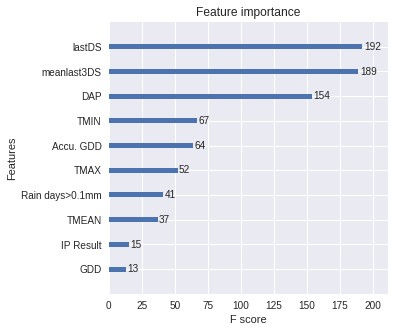

In [210]:
xgb.plot_importance(xgbFinal)

In [216]:
xgbFinal_train_preds = xgbFinal.predict(X_train)
xgbFinal_test_preds = xgbFinal.predict(X_test)


AttributeError: ignored

In [ ]:
rmse = np.sqrt(mean_squared_error(y_test, preds))
rrmse = np.sqrt(mean_squared_error(y_test, preds))/np.mean(y_test)
print("RMSE: %f" % (rmse*100))
print("RRMSE: %f " % (rrmse*100))